#### Import Essential Libraries

In [793]:
import pandas as pd
import numpy as np

#### Import Data Visualization Libraries

In [794]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import altair as alt 

#### Import Preprocessing Packages

##### To create training and testing datasets 

In [795]:
from sklearn.model_selection import train_test_split 

##### To impute the data

In [796]:
from sklearn.impute import SimpleImputer, KNNImputer

##### To standarize and scale the data correctly 

In [797]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder 

##### To create the pipeline

In [798]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

##### To Evaluate Quality of Logistic Regression Model

In [799]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    roc_curve,
    roc_auc_score
)
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import classification_report

#### Create a random seed for reproducability

In [800]:
random_seed = 172193
np.random.seed(random_seed)

---

### Load in the dataset

In [801]:
edp_df = pd.read_excel('Employee_Data_Project.xlsx')
print(f'The Dataset shape is: {edp_df.shape}')

The Dataset shape is: (4410, 18)


### Look at the data structure

In [802]:
print(edp_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   DistanceFromHome         4410 non-null   int64  
 4   Education                4410 non-null   int64  
 5   EmployeeID               4410 non-null   int64  
 6   Gender                   4410 non-null   object 
 7   JobLevel                 4410 non-null   int64  
 8   MaritalStatus            4410 non-null   object 
 9   Income                   4410 non-null   int64  
 10  NumCompaniesWorked       4391 non-null   float64
 11  StandardHours            4410 non-null   int64  
 12  TotalWorkingYears        4401 non-null   float64
 13  TrainingTimesLastYear    4410 non-null   int64  
 14  YearsAtCompany          

---

### Check the rows with nulls 

In [803]:
missing = edp_df.isna().sum()
## to get the percentage missing (divide by the length of the dataframe)
missing_pct = (missing / len(edp_df)) *100

print(missing)
print(missing_pct)

Age                         0
Attrition                   0
BusinessTravel              0
DistanceFromHome            0
Education                   0
EmployeeID                  0
Gender                      0
JobLevel                    0
MaritalStatus               0
Income                      0
NumCompaniesWorked         19
StandardHours               0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsWithCurrManager        0
EnvironmentSatisfaction    25
JobSatisfaction            20
dtype: int64
Age                        0.000000
Attrition                  0.000000
BusinessTravel             0.000000
DistanceFromHome           0.000000
Education                  0.000000
EmployeeID                 0.000000
Gender                     0.000000
JobLevel                   0.000000
MaritalStatus              0.000000
Income                     0.000000
NumCompaniesWorked         0.430839
StandardHours              0.000000
TotalWorkingYea

---

In [804]:
edp_df['StandardHours'].nunique()


1

##### Since standard hours is all constant, will drop this column

---

In [805]:
edp_df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DistanceFromHome', 'Education',
       'EmployeeID', 'Gender', 'JobLevel', 'MaritalStatus', 'Income',
       'NumCompaniesWorked', 'StandardHours', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsWithCurrManager',
       'EnvironmentSatisfaction', 'JobSatisfaction'],
      dtype='object')

In [806]:
target_variable = 'Attrition'
drop_columns = ['EmployeeID' , 'StandardHours']
numeric_variables = ['Age' , 'DistanceFromHome' , 'Income' , 'NumCompaniesWorked' , 'TotalWorkingYears' , 'TrainingTimesLastYear'
            , 'YearsAtCompany' , 'YearsWithCurrManager']
ordinal_variables = ['Education' , 'JobLevel' , 'EnvironmentSatisfaction' , 'JobSatisfaction']
nominal_variables = ['Gender' , 'BusinessTravel' , 'MaritalStatus']


---

In [807]:
edp_df['Attrition_lab'] = edp_df['Attrition'].map({'Yes':1 , 'No' :0})


---

In [808]:
X = edp_df[numeric_variables+ordinal_variables+nominal_variables].copy()
y= edp_df['Attrition_lab'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_seed)

---

### Build Preprocessing Pipeline 

#### Transform numeric, nominal, and ordinal columns 
#### KNN imputation for numerical columns

In [809]:
numeric_imputation = Pipeline(steps = [(
    'imputer' , KNNImputer(n_neighbors=5 , weights='uniform')),
('scaler' , StandardScaler())])

#### Nominal Variables: use onehotencoding and replace nulls with the mode (most frequent)

In [810]:
nominal_imputation = Pipeline(steps=[(
'imputer' , SimpleImputer(strategy= 'most_frequent')),
('one_hot_encoder' , OneHotEncoder(handle_unknown= 'ignore' , sparse_output= False , drop = 'first'))])

#### Ordinal Variables: replace with the median 

In [811]:
ordinal_imputation = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'median'))])

In [812]:
pre_process = ColumnTransformer(transformers = [('numeric', numeric_imputation, numeric_variables),
                                                ('ordinal', ordinal_imputation, ordinal_variables),
                                                ('nominal', nominal_imputation, nominal_variables)])


In [813]:
X_train_processed = pre_process.fit_transform(X_train)  
X_test_processed = pre_process.transform(X_test)


In [814]:
feature_names = pre_process.get_feature_names_out()
feature_names

array(['numeric__Age', 'numeric__DistanceFromHome', 'numeric__Income',
       'numeric__NumCompaniesWorked', 'numeric__TotalWorkingYears',
       'numeric__TrainingTimesLastYear', 'numeric__YearsAtCompany',
       'numeric__YearsWithCurrManager', 'ordinal__Education',
       'ordinal__JobLevel', 'ordinal__EnvironmentSatisfaction',
       'ordinal__JobSatisfaction', 'nominal__Gender_Male',
       'nominal__BusinessTravel_Travel_Frequently',
       'nominal__BusinessTravel_Travel_Rarely',
       'nominal__MaritalStatus_Married', 'nominal__MaritalStatus_Single'],
      dtype=object)

In [815]:
X_train_processed_df = pd.DataFrame(X_train_processed, columns = feature_names)
X_test_processed_df = pd.DataFrame(X_test_processed, columns = feature_names)

X_train_processed_df

,numeric__Age,numeric__DistanceFromHome,numeric__Income,numeric__NumCompaniesWorked,numeric__TotalWorkingYears,numeric__TrainingTimesLastYear,numeric__YearsAtCompany,numeric__YearsWithCurrManager,ordinal__Education,ordinal__JobLevel,ordinal__EnvironmentSatisfaction,ordinal__JobSatisfaction,nominal__Gender_Male,nominal__BusinessTravel_Travel_Frequently,nominal__BusinessTravel_Travel_Rarely,nominal__MaritalStatus_Married,nominal__MaritalStatus_Single
0,-0.204878,-0.155259,-0.574737,-0.666602,-1.304028,-0.601912,-0.980175,-0.866629,4.0,3.0,4.0,4.0,0.0,0.0,1.0,1.0,0.0
1,1.009692,-0.892809,2.148524,2.148666,2.151124,0.960832,3.110955,1.365332,3.0,2.0,3.0,1.0,1.0,0.0,1.0,1.0,0.0
2,0.126368,1.319841,-0.962122,0.137760,1.127376,0.179460,1.801793,1.923322,4.0,2.0,2.0,3.0,0.0,0.0,1.0,1.0,0.0
3,0.788861,2.426165,-0.978826,0.539942,-0.152310,0.960832,-0.816530,-0.587634,4.0,2.0,1.0,3.0,1.0,0.0,1.0,0.0,1.0
4,-2.081942,-1.015734,-0.896595,-0.666602,-1.431996,0.179460,-1.143820,-1.145624,4.0,1.0,3.0,3.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3082,-0.425709,0.582291,0.920412,0.942123,-0.024342,-0.601912,0.328987,0.807342,3.0,1.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0
3083,0.126368,0.459366,-0.709219,-1.068783,-1.048091,1.742204,-0.816530,-0.587634,3.0,1.0,3.0,3.0,1.0,1.0,0.0,1.0,0.0
3084,1.230523,-0.401109,0.927693,-0.264421,0.359564,2.523576,0.328987,0.807342,3.0,1.0,2.0,4.0,1.0,0.0,1.0,1.0,0.0
3085,0.568030,1.688615,-0.830853,-1.068783,1.255344,0.179460,2.129084,1.365332,3.0,3.0,3.0,1.0,0.0,0.0,1.0,1.0,0.0


#### Verify if there are now any nulls in the processed dataset

In [816]:
print(X_train_processed_df.isna().sum())
print(X_test_processed_df.isna().sum())

numeric__Age                                 0
numeric__DistanceFromHome                    0
numeric__Income                              0
numeric__NumCompaniesWorked                  0
numeric__TotalWorkingYears                   0
numeric__TrainingTimesLastYear               0
numeric__YearsAtCompany                      0
numeric__YearsWithCurrManager                0
ordinal__Education                           0
ordinal__JobLevel                            0
ordinal__EnvironmentSatisfaction             0
ordinal__JobSatisfaction                     0
nominal__Gender_Male                         0
nominal__BusinessTravel_Travel_Frequently    0
nominal__BusinessTravel_Travel_Rarely        0
nominal__MaritalStatus_Married               0
nominal__MaritalStatus_Single                0
dtype: int64
numeric__Age                                 0
numeric__DistanceFromHome                    0
numeric__Income                              0
numeric__NumCompaniesWorked                  0


#### Confirmed that now there are no NAs

----

### Downsample

##### During the Preprocessing Pipeline, was converted to a np.array 
##### Convert to np.array to match X_train_processed

In [817]:
y_train_array = y_train.values
positive_index = np.where(y_train_array == 1)[0]
negative_index = np.where(y_train_array == 0 )[0]

### Set randomseed again 

In [818]:
np.random.seed(random_seed)
keep_negative= np.random.choice(negative_index, size = len(positive_index), replace = False)
keep_index = np.concatenate([positive_index, keep_negative])

y_train_balanced = y_train_array[keep_index]
X_train_balanced = X_train_processed[keep_index]

In [819]:
y_train_balanced_df = pd.DataFrame(y_train_balanced , columns= ['Attrition_lab'])
X_train_processed_balanced_df = pd.DataFrame(X_train_balanced , columns = feature_names)

---

# Output: 
- X_train_processed_balanced_df (downampled and preprocessed with KNN+simple imputer)
- X_train_processed_df (preprocessed not downsampled)
- y_train_balanced (use with X_train_processsed_balanced_df)
- y_train (use with X_train_processed_df)
- X_test_processed_df (preprocessed with KNN+simple imputer pipeline)
- y_test (use with X_test_processed)

- y_train_balanced_df can be used however will need to do y_train_balanced_df_values.ravel() (this is since model fit requires 1d array)



---

#### Test to see if this works with logistic regression model

## Full Data: X_test_processed_df

#### Initiate Logistic Regression Model

In [820]:
log_reg = LogisticRegression(
    solver="lbfgs",
    max_iter=1000
)

#### Fit Logistic Regression Model

In [821]:
log_reg.fit(X_train_processed_balanced_df, y_train_balanced_df.values.ravel()) 

LogisticRegression(max_iter=1000)

#### Predictions

In [822]:
y_pred_full_data = log_reg.predict(X_test_processed_df)

#### Print Test AUC

In [823]:
print("Test AUC (median imputation + standardization):", roc_auc_score(y_test, y_pred_full_data))

Test AUC (median imputation + standardization): 0.67638624540033


#### Probabilities

In [824]:
y_prob_full_data = log_reg.predict_proba(X_test_processed_df)
print(y_prob_full_data)

[[0.55942533 0.44057467]
 [0.62255083 0.37744917]
 [0.44778131 0.55221869]
 ...
 [0.3694525  0.6305475 ]
 [0.85662624 0.14337376]
 [0.34968883 0.65031117]]


### Evaluate Logistic Regression Model

#### Confusion Matrix

In [825]:
print(confusion_matrix(y_test, y_pred_full_data))

[[772 338]
 [ 73 140]]


#### ROC Calculation

In [826]:
y_prob_ROC = log_reg.predict_proba(X_test_processed_df)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_ROC)

#### AUC Calculation

In [827]:
auc = roc_auc_score(y_test, y_prob_ROC)

#### Plot ROC Curve

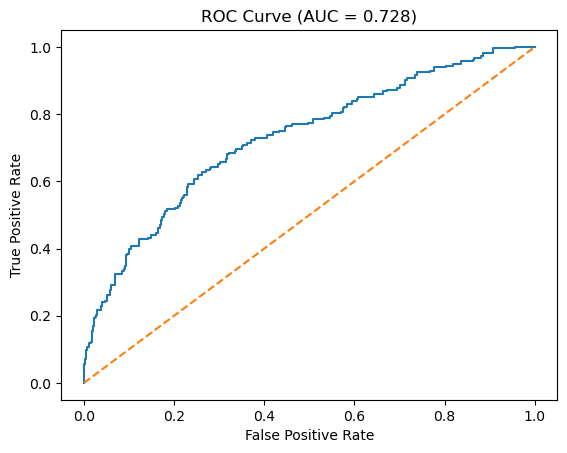

In [828]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")  # random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {auc:.3f})")
plt.show()

#### Classification Report

In [829]:
print(classification_report(y_test, y_pred_full_data))

              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1110
           1       0.29      0.66      0.41       213

    accuracy                           0.69      1323
   macro avg       0.60      0.68      0.60      1323
weighted avg       0.81      0.69      0.73      1323



#### Inspect Coefficients

In [830]:
coefficients_log_reg = pd.DataFrame({
    "feature": X_test_processed_df.columns,
    "coefficient": log_reg.coef_[0]
})

coefficients_log_reg

,feature,coefficient
0,numeric__Age,-0.188005
1,numeric__DistanceFromHome,0.047046
2,numeric__Income,-0.057745
3,numeric__NumCompaniesWorked,0.150209
4,numeric__TotalWorkingYears,-0.451246
5,numeric__TrainingTimesLastYear,-0.133343
6,numeric__YearsAtCompany,0.441717
7,numeric__YearsWithCurrManager,-0.611985
8,ordinal__Education,-0.116350
9,ordinal__JobLevel,-0.013396


In [831]:
log_reg.coef_

array([[-0.1880051 ,  0.04704605, -0.05774475,  0.15020946, -0.45124598,
        -0.13334291,  0.44171691, -0.61198521, -0.11635038, -0.013396  ,
        -0.29012361, -0.310513  ,  0.08101772,  1.33468432,  0.9117084 ,
         0.12305924,  0.8513843 ]])

In [832]:
log_reg.intercept_

array([0.39560728])

In [833]:
log_reg.n_features_in_

17

In [834]:
coefficients_log_reg["odds_ratio"] = np.exp(coefficients_log_reg["coefficient"])
coefficients_log_reg

,feature,coefficient,odds_ratio
0,numeric__Age,-0.188005,0.828610
1,numeric__DistanceFromHome,0.047046,1.048170
2,numeric__Income,-0.057745,0.943891
3,numeric__NumCompaniesWorked,0.150209,1.162078
4,numeric__TotalWorkingYears,-0.451246,0.636834
5,numeric__TrainingTimesLastYear,-0.133343,0.875165
6,numeric__YearsAtCompany,0.441717,1.555375
7,numeric__YearsWithCurrManager,-0.611985,0.542273
8,ordinal__Education,-0.116350,0.890163
9,ordinal__JobLevel,-0.013396,0.986693


In [835]:
coefficients_log_reg['odds_mfx'] = coefficients_log_reg['odds_ratio'] - 1
coefficients_log_reg

,feature,coefficient,odds_ratio,odds_mfx
0,numeric__Age,-0.188005,0.828610,-0.171390
1,numeric__DistanceFromHome,0.047046,1.048170,0.048170
2,numeric__Income,-0.057745,0.943891,-0.056109
3,numeric__NumCompaniesWorked,0.150209,1.162078,0.162078
4,numeric__TotalWorkingYears,-0.451246,0.636834,-0.363166
5,numeric__TrainingTimesLastYear,-0.133343,0.875165,-0.124835
6,numeric__YearsAtCompany,0.441717,1.555375,0.555375
7,numeric__YearsWithCurrManager,-0.611985,0.542273,-0.457727
8,ordinal__Education,-0.116350,0.890163,-0.109837
9,ordinal__JobLevel,-0.013396,0.986693,-0.013307


## Downsample: X_test_processed_balance_df

#### Inititiate Logistic Regression

In [836]:
log_reg_downsample = LogisticRegression(
    solver="lbfgs",
    max_iter=1000
)

#### Fit Logistic Regression Model

In [837]:
log_reg_downsample.fit(X_train_processed_df, y_train.values.ravel())

LogisticRegression(max_iter=1000)

#### Predictions

In [838]:
y_pred_downsample = log_reg_downsample.predict(X_test_processed_df)

#### Print Test AUC

In [839]:
print("Test AUC (median imputation + standardization):", roc_auc_score(y_test, y_pred_downsample))

Test AUC (median imputation + standardization): 0.5579748762847355


#### Probabilities

In [840]:
y_prob_downsample = log_reg_downsample.predict_proba(X_test_processed_df)
print(y_prob_downsample)

[[0.87010979 0.12989021]
 [0.91422873 0.08577127]
 [0.79088398 0.20911602]
 ...
 [0.7426327  0.2573673 ]
 [0.96891755 0.03108245]
 [0.68196254 0.31803746]]


### Evaluate Logistic Regression Model

#### Confusion Matrix

In [841]:
print(confusion_matrix(y_test, y_pred_downsample))

[[1098   12]
 [ 186   27]]


#### ROC Calculation

In [842]:
y_prob_ROC_downsample = log_reg_downsample.predict_proba(X_test_processed_df)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_ROC_downsample)

### AUC Calculation

In [843]:
auc = roc_auc_score(y_test, y_prob_ROC_downsample)

#### ROC Curve Plot

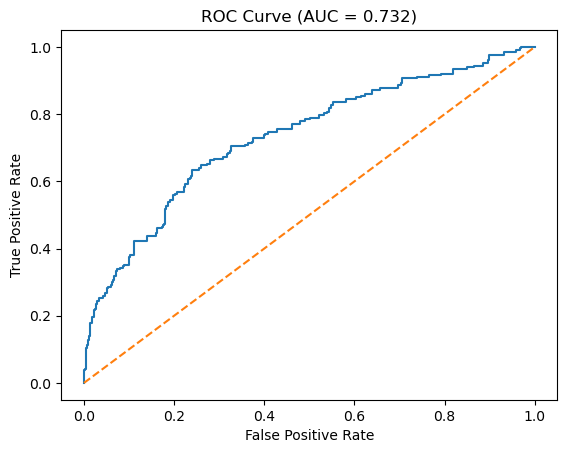

In [844]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")  # random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {auc:.3f})")
plt.show()

#### Classification Report

In [845]:
print(classification_report(y_test, y_pred_downsample))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1110
           1       0.69      0.13      0.21       213

    accuracy                           0.85      1323
   macro avg       0.77      0.56      0.57      1323
weighted avg       0.83      0.85      0.80      1323



#### Inspect Coefficients

In [846]:
coefficients_downsample = pd.DataFrame({
    "feature": X_test_processed_df.columns,
    "coefficient": log_reg_downsample.coef_[0]
})

coefficients_downsample

,feature,coefficient
0,numeric__Age,-0.252677
1,numeric__DistanceFromHome,0.025336
2,numeric__Income,-0.062980
3,numeric__NumCompaniesWorked,0.247845
4,numeric__TotalWorkingYears,-0.517241
5,numeric__TrainingTimesLastYear,-0.153295
6,numeric__YearsAtCompany,0.325534
7,numeric__YearsWithCurrManager,-0.524518
8,ordinal__Education,-0.100696
9,ordinal__JobLevel,-0.067359


In [847]:
log_reg_downsample.coef_

array([[-0.25267742,  0.02533553, -0.06297974,  0.2478449 , -0.51724111,
        -0.15329486,  0.32553447, -0.52451779, -0.10069577, -0.06735894,
        -0.31524227, -0.2979415 ,  0.06865901,  1.22101902,  0.60963922,
         0.02024178,  0.98360536]])

In [848]:
log_reg_downsample.intercept_

array([-0.94269683])

In [849]:
log_reg_downsample.n_features_in_

17

In [850]:
coefficients_downsample["odds_ratio"] = np.exp(coefficients_downsample["coefficient"])
coefficients_downsample

,feature,coefficient,odds_ratio
0,numeric__Age,-0.252677,0.776718
1,numeric__DistanceFromHome,0.025336,1.025659
2,numeric__Income,-0.062980,0.938963
3,numeric__NumCompaniesWorked,0.247845,1.281261
4,numeric__TotalWorkingYears,-0.517241,0.596163
5,numeric__TrainingTimesLastYear,-0.153295,0.857877
6,numeric__YearsAtCompany,0.325534,1.384771
7,numeric__YearsWithCurrManager,-0.524518,0.591841
8,ordinal__Education,-0.100696,0.904208
9,ordinal__JobLevel,-0.067359,0.934860


In [851]:
coefficients_downsample['odds_mfx'] = coefficients_downsample['odds_ratio'] - 1
coefficients_downsample

,feature,coefficient,odds_ratio,odds_mfx
0,numeric__Age,-0.252677,0.776718,-0.223282
1,numeric__DistanceFromHome,0.025336,1.025659,0.025659
2,numeric__Income,-0.062980,0.938963,-0.061037
3,numeric__NumCompaniesWorked,0.247845,1.281261,0.281261
4,numeric__TotalWorkingYears,-0.517241,0.596163,-0.403837
5,numeric__TrainingTimesLastYear,-0.153295,0.857877,-0.142123
6,numeric__YearsAtCompany,0.325534,1.384771,0.384771
7,numeric__YearsWithCurrManager,-0.524518,0.591841,-0.408159
8,ordinal__Education,-0.100696,0.904208,-0.095792
9,ordinal__JobLevel,-0.067359,0.934860,-0.065140
